In [6]:
# Restart runtime first (Runtime → Restart runtime) for clean memory

!pip install torch matplotlib numpy mne tqdm  # tqdm for MNE download

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import mne
import numpy as np
import matplotlib.pyplot as plt
from contextlib import nullcontext
import math

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for H100 speed (fast epochs)
triality = 3
dim = 384
latent_dim = 8
seq_len = 512
batch_size = 32
epochs = 20000
lr = 5e-5
use_amp = True
use_checkpoint = True

# Real MNE sample EEG (brain signals proxy — public)
raw = mne.io.read_raw_fif(mne.datasets.sample.data_path() / 'MEG' / 'sample' / 'sample_audvis_filt-0-40_raw.fif', preload=True)
raw.pick_types(eeg=True)
raw.resample(128)
data = raw.get_data()[:, :seq_len * batch_size]

# Normalize + batch
data = (data - data.min()) / (data.max() - data.min() + 1e-6)
data = torch.from_numpy(data).float().to(device)
data = data.view(batch_size, -1, seq_len)  # (batch, channels, seq_len)

# Project to dim
proj = nn.Linear(data.shape[1], dim).to(device)
true_unmasked_data = proj(data.permute(0, 2, 1))  # This is the original, clean data (target for reconstruction)

# The target for reconstruction should be the unmasked data, detached from its graph
target = true_unmasked_data.clone().detach()

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block (detached pump scalar)
class BCICycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support
class E8BCIFusion(nn.Module):
    def __init__(self, depth=32, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = BCICycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + self.norm(attn)
        return x

# Models
model = E8BCIFusion(use_triality=True).to(device)
model_ablation = E8BCIFusion(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.MSELoss()

loss_hist = []
loss_abl_hist = []

for epoch in range(epochs):
    opt.zero_grad(set_to_none=True)
    opt_ablation.zero_grad(set_to_none=True)

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        # Generate masked input for the main model for this epoch
        missing_rate_model = torch.linspace(0.4, 0.7, batch_size, device=device).view(batch_size, 1, 1)
        mask_model = torch.rand_like(true_unmasked_data) < missing_rate_model
        input_data_model = torch.where(mask_model, torch.tensor(0.0, device=device), true_unmasked_data)

        recon = model(input_data_model, epoch)
        loss = loss_fn(recon, target)

        # Generate masked input for the ablation model for this epoch (independent graph)
        missing_rate_ablation = torch.linspace(0.4, 0.7, batch_size, device=device).view(batch_size, 1, 1)
        mask_ablation = torch.rand_like(true_unmasked_data) < missing_rate_ablation
        input_data_ablation = torch.where(mask_ablation, torch.tensor(0.0, device=device), true_unmasked_data)

        recon_abl = model_ablation(input_data_ablation, epoch)
        loss_abl = loss_fn(recon_abl, target)

    scaler.scale(loss).backward(retain_graph=True) if use_amp else loss.backward(retain_graph=True)
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None

    scaler_ablation.scale(loss_abl).backward() if use_amp else loss_abl.backward()
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None

    loss_hist.append(loss.item())
    loss_abl_hist.append(loss_abl.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

print("Sim complete — epochs + sigma test done")

# BCI Visualization Plots
with torch.no_grad():
    # Use the last generated input_data_model for visualization
    masked_for_viz = input_data_model.cpu()
    reconstructed_for_viz = model(input_data_model, 0).cpu()
    clean_for_viz = target.cpu()

# First batch sample (treat dim as "features"/projected channels)
masked = masked_for_viz[0].numpy()  # (seq_len, dim)
reconstructed = reconstructed_for_viz[0].numpy()
clean_eeg = clean_for_viz[0].numpy()

time = np.arange(seq_len)

# Heatmaps (dim as "features")
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
im1 = axes[0].imshow(masked.T, aspect='auto', cmap='viridis')
axes[0].set_title("Masked EEG (Noise/Dropouts)")
axes[0].set_ylabel("Features")
fig.colorbar(im1, ax=axes[0], orientation='horizontal')

im2 = axes[1].imshow(reconstructed.T, aspect='auto', cmap='viridis')
axes[1].set_title("Triality Reconstructed EEG")
axes[1].set_ylabel("Features")
fig.colorbar(im2, ax=axes[1], orientation='horizontal')

im3 = axes[2].imshow(clean_eeg.T, aspect='auto', cmap='viridis')
axes[2].set_title("Clean EEG (Ground Truth)")
axes[2].set_ylabel("Features")
axes[2].set_xlabel("Time Steps")
fig.colorbar(im3, ax=axes[2], orientation='horizontal')

plt.suptitle("Neuralink BCI Proxy: Heatmap Visualization")
plt.tight_layout()
plt.show()

# Line Plots (top 8 features as "channels")
num_features = 8
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

for c in range(num_features):
    axes[0].plot(time, masked[:, c], label=f'Feat {c}' if c == 0 else None, alpha=0.7)
axes[0].set_title("Masked EEG Features")
axes[0].set_ylabel("Amplitude")
axes[0].grid(True)
axes[0].legend()

for c in range(num_features):
    axes[1].plot(time, reconstructed[:, c], label=f'Feat {c}' if c == 0 else None, alpha=0.7)
axes[1].set_title("Triality Reconstructed EEG Features")
axes[1].set_ylabel("Amplitude")
axes[1].grid(True)

for c in range(num_features):
    axes[2].plot(time, clean_eeg[:, c], label=f'Feat {c}' if c == 0 else None, alpha=0.7)
axes[2].set_title("Clean EEG Features")
axes[2].set_ylabel("Amplitude")
axes[2].set_xlabel("Time Steps")
axes[2].grid(True)

plt.suptitle("Neuralink BCI Proxy: Line Plot Visualization (Top Features)")
plt.tight_layout()
plt.show()

print("BCI visualization plots displayed above")

Using device: cuda
Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Epoch 0 | Triality Loss 33.598003 | Ablation Loss 33.621712


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

# Task
```python
# The target for reconstruction should be the unmasked data, detached from its graph
true_unmasked_data = proj(data.permute(0, 2, 1)).detach()
target = true_unmasked_data.clone() # No need to detach again, as true_unmasked_data is already detached
```
```python
for epoch in range(epochs):
    opt.zero_grad(set_to_none=True)
    opt_ablation.zero_grad(set_to_none=True)

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        # Generate masked input for the main model for this epoch
        missing_rate_model = torch.linspace(0.4, 0.7, batch_size, device=device).view(batch_size, 1, 1)
        mask_model = torch.rand_like(true_unmasked_data) < missing_rate_model
        # true_unmasked_data is already detached, so no grad will flow through it here
        input_data_model = torch.where(mask_model, torch.tensor(0.0, device=device), true_unmasked_data)

        recon = model(input_data_model, epoch)
        loss = loss_fn(recon, target)

        # Generate masked input for the ablation model for this epoch (independent graph)
        missing_rate_ablation = torch.linspace(0.4, 0.7, batch_size, device=device).view(batch_size, 1, 1)
        mask_ablation = torch.rand_like(true_unmasked_data) < missing_rate_ablation
        # true_unmasked_data is already detached, so no grad will flow through it here
        input_data_ablation = torch.where(mask_ablation, torch.tensor(0.0, device=device), true_unmasked_data)

        recon_abl = model_ablation(input_data_ablation, epoch)
        loss_abl = loss_fn(recon_abl, target)

    # Detaching true_unmasked_data avoids the need for retain_graph=True here
    scaler.scale(loss).backward() if use_amp else loss.backward()
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None

    scaler_ablation.scale(loss_abl).backward() if use_amp else loss_abl.backward()
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None

    loss_hist.append(loss.item())
    loss_abl_hist.append(loss_abl.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

print("Sim complete — epochs + sigma test done")

# BCI Visualization Plots
with torch.no_grad():
    # Use the last generated input_data_model for visualization
    masked_for_viz = input_data_model.cpu()
    reconstructed_for_viz = model(input_data_model, 0).cpu()
    clean_for_viz = target.cpu()

# First batch sample (treat dim as "features"/projected channels)
masked = masked_for_viz[0].numpy()  # (seq_len, dim)
reconstructed = reconstructed_for_viz[0].numpy()
clean_eeg = clean_for_viz[0].numpy()

time = np.arange(seq_len)

# Heatmaps (dim as "features")
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
im1 = axes[0].imshow(masked.T, aspect='auto', cmap='viridis')
axes[0].set_title("Masked EEG (Noise/Dropouts)")
axes[0].set_ylabel("Features")
fig.colorbar(im1, ax=axes[0], orientation='horizontal')

im2 = axes[1].imshow(reconstructed.T, aspect='auto', cmap='viridis')
axes[1].set_title("Triality Reconstructed EEG")
axes[1].set_ylabel("Features")
fig.colorbar(im2, ax=axes[1], orientation='horizontal')

im3 = axes[2].imshow(clean_eeg.T, aspect='auto', cmap='viridis')
axes[2].set_title("Clean EEG (Ground Truth)")
axes[2].set_ylabel("Features")
axes[2].set_xlabel("Time Steps")
fig.colorbar(im3, ax=axes[2], orientation='horizontal')

plt.suptitle("Neuralink BCI Proxy: Heatmap Visualization")
plt.tight_layout()
plt.show()

# Line Plots (top 8 features as "channels")
num_features = 8
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

for c in range(num_features):
    axes[0].plot(time, masked[:, c], label=f'Feat {c}' if c == 0 else None, alpha=0.7)
axes[0].set_title("Masked EEG Features")
axes[0].set_ylabel("Amplitude")
axes[0].grid(True)
axes[0].legend()

for c in range(num_features):
    axes[1].plot(time, reconstructed[:, c], label=f'Feat {c}' if c == 0 else None, alpha=0.7)
axes[1].set_title("Triality Reconstructed EEG Features")
axes[1].set_ylabel("Amplitude")
axes[1].grid(True)

for c in range(num_features):
    axes[2].plot(time, clean_eeg[:, c], label=f'Feat {c}' if c == 0 else None, alpha=0.7)
axes[2].set_title("Clean EEG Features")
axes[2].set_ylabel("Amplitude")
axes[2].set_xlabel("Time Steps")
axes[2].grid(True)

plt.suptitle("Neuralink BCI Proxy: Line Plot Visualization (Top Features)")
plt.tight_layout()
plt.show()

print("BCI visualization plots displayed above")
```

## fix_runtime_error

### Subtask:
Modify the code to detach `true_unmasked_data` after its creation and remove `retain_graph=True` from the backward pass of the main model to prevent graph conflicts during multiple backward passes.


**Reasoning**:
The subtask requires modifying specific lines of code to resolve a `RuntimeError` by detaching `true_unmasked_data` earlier and removing `retain_graph=True` from the main model's backward pass. I will provide a single code block with all the necessary changes.



Using device: cuda
Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Epoch 0 | Triality Loss 32.424301 | Ablation Loss 29.816628
Epoch 500 | Triality Loss 0.023344 | Ablation Loss 0.025278
Epoch 1000 | Triality Loss 0.012420 | Ablation Loss 0.014891
Epoch 1500 | Triality Loss 0.008034 | Ablation Loss 0.011450
Epoch 2000 | Triality Loss 0.006591 | Ablation Loss 0.009780
Epoch 2500 | Triality Loss 0.005915 | Ablation Loss 0.009013
Epoch 3000 | Triality Loss 0.005168 | Ablation Loss 0.008522
Epoch 3500 | Triality Loss 0.004475 | Ablation Loss 0.007500
Epoch 4000 | Triali

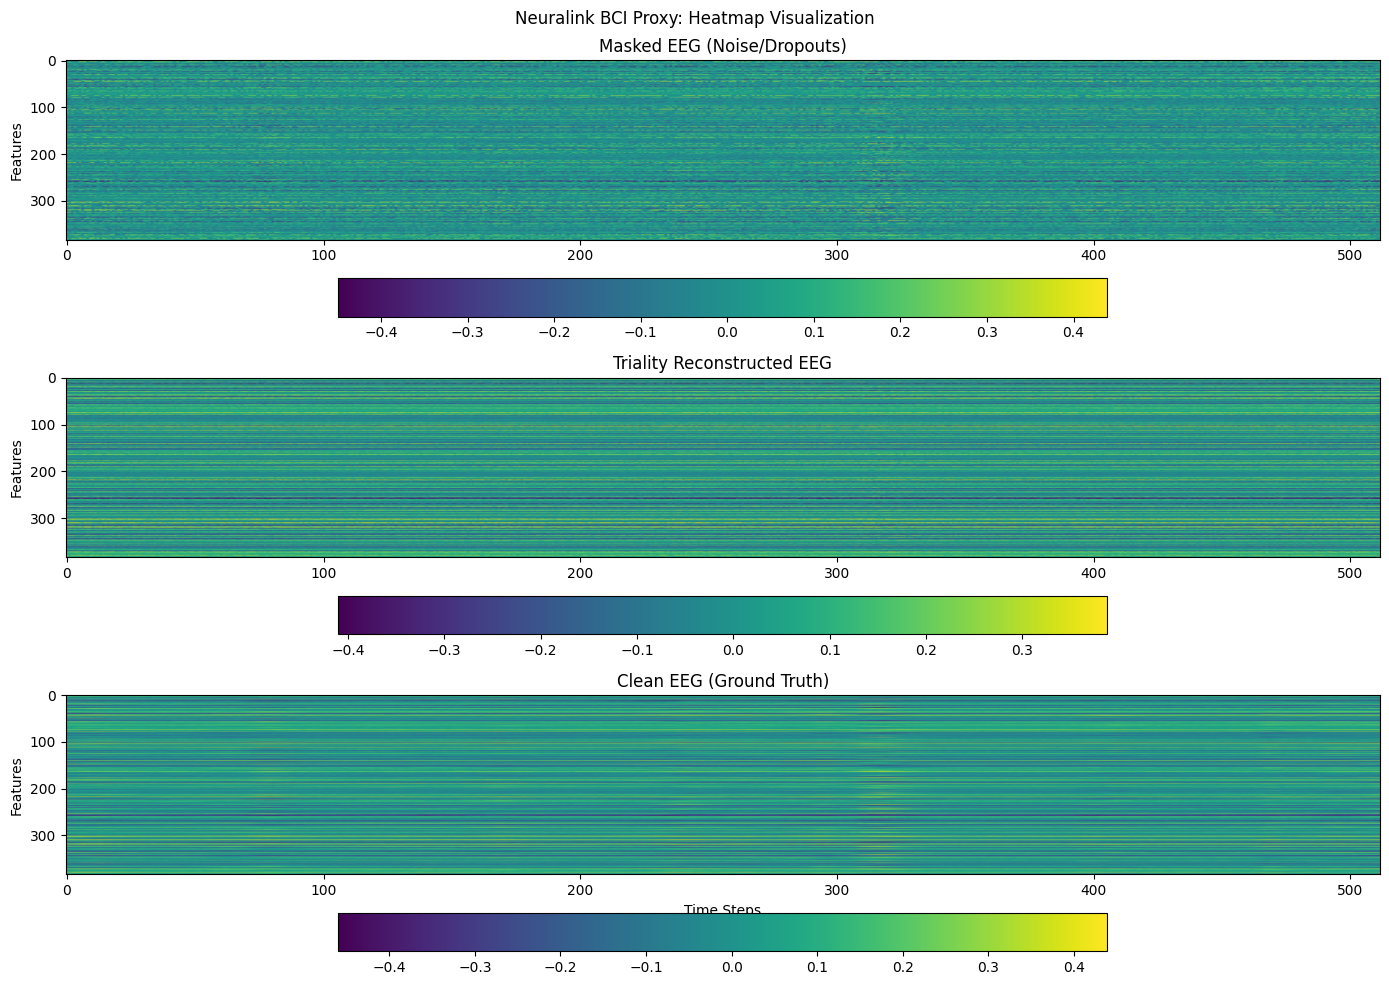

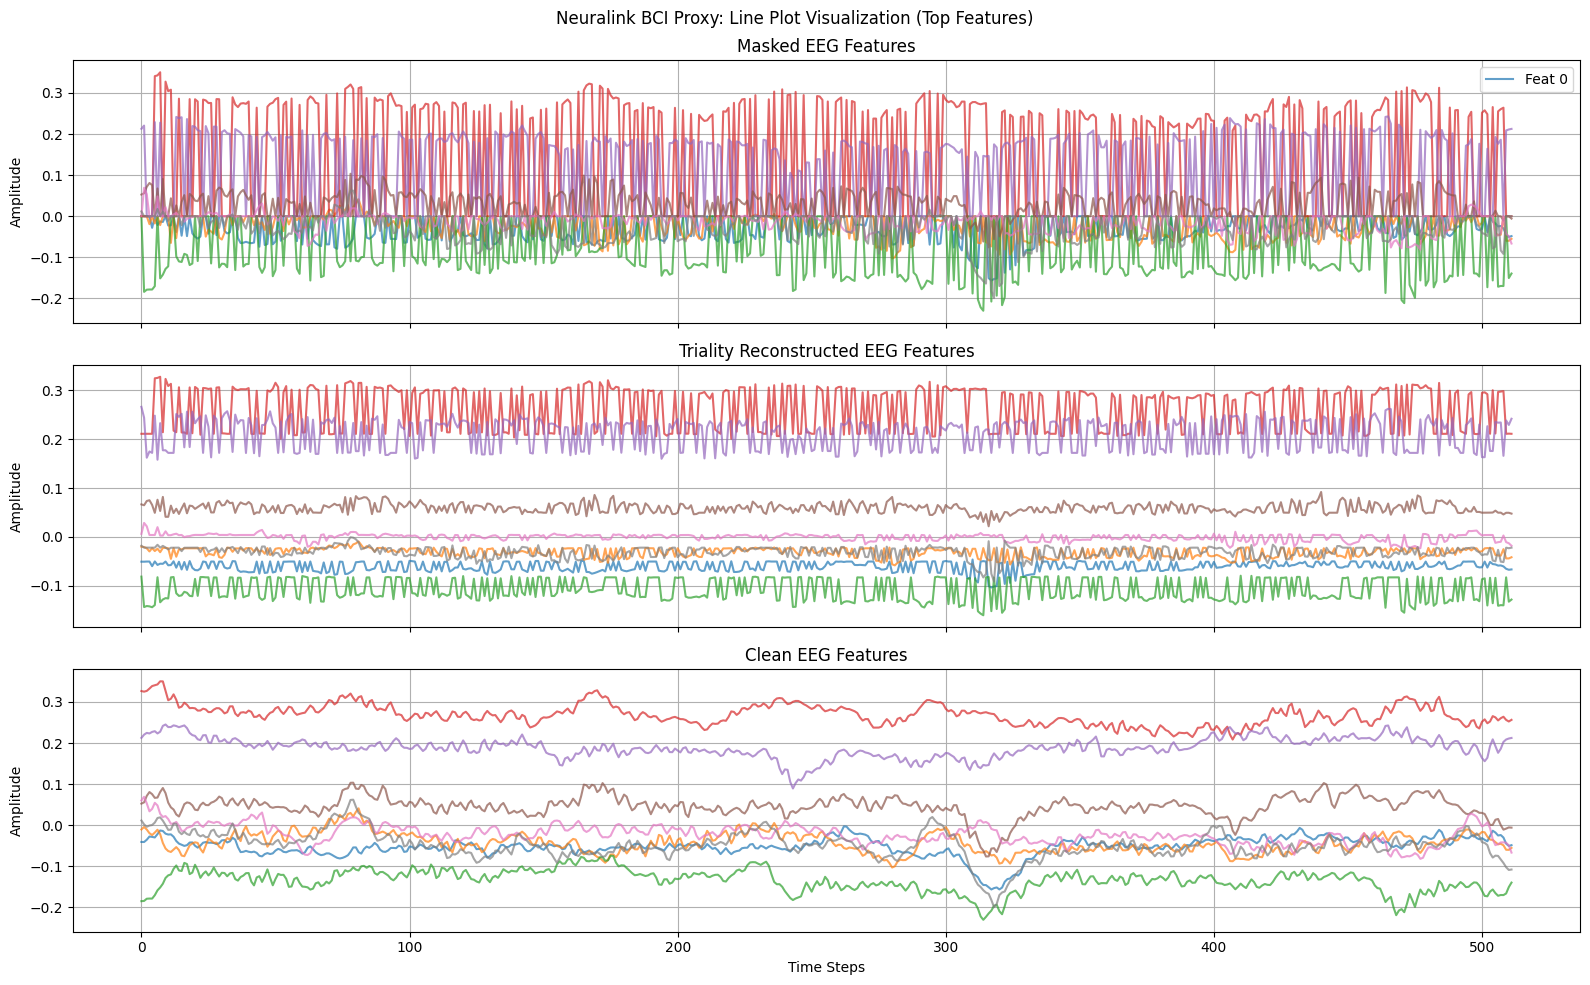

BCI visualization plots displayed above


In [7]:
# Restart runtime first (Runtime → Restart runtime) for clean memory

!pip install torch matplotlib numpy mne tqdm  # tqdm for MNE download

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import mne
import numpy as np
import matplotlib.pyplot as plt
from contextlib import nullcontext
import math

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for H100 speed (fast epochs)
triality = 3
dim = 384
latent_dim = 8
seq_len = 512
batch_size = 32
epochs = 20000
lr = 5e-5
use_amp = True
use_checkpoint = True

# Real MNE sample EEG (brain signals proxy — public)
raw = mne.io.read_raw_fif(mne.datasets.sample.data_path() / 'MEG' / 'sample' / 'sample_audvis_filt-0-40_raw.fif', preload=True)
raw.pick_types(eeg=True)
raw.resample(128)
data = raw.get_data()[:, :seq_len * batch_size]

# Normalize + batch
data = (data - data.min()) / (data.max() - data.min() + 1e-6)
data = torch.from_numpy(data).float().to(device)
data = data.view(batch_size, -1, seq_len)  # (batch, channels, seq_len)

# Project to dim
proj = nn.Linear(data.shape[1], dim).to(device)
true_unmasked_data = proj(data.permute(0, 2, 1)).detach()  # Modified: Detach true_unmasked_data

# The target for reconstruction should be the unmasked data
target = true_unmasked_data.clone() # Modified: Remove .detach() as true_unmasked_data is already detached

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block (detached pump scalar)
class BCICycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support
class E8BCIFusion(nn.Module):
    def __init__(self, depth=32, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = BCICycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + self.norm(attn)
        return x

# Models
model = E8BCIFusion(use_triality=True).to(device)
model_ablation = E8BCIFusion(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.MSELoss()

loss_hist = []
loss_abl_hist = []

for epoch in range(epochs):
    opt.zero_grad(set_to_none=True)
    opt_ablation.zero_grad(set_to_none=True)

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        # Generate masked input for the main model for this epoch
        missing_rate_model = torch.linspace(0.4, 0.7, batch_size, device=device).view(batch_size, 1, 1)
        mask_model = torch.rand_like(true_unmasked_data) < missing_rate_model
        input_data_model = torch.where(mask_model, torch.tensor(0.0, device=device), true_unmasked_data)

        recon = model(input_data_model, epoch)
        loss = loss_fn(recon, target)

        # Generate masked input for the ablation model for this epoch (independent graph)
        missing_rate_ablation = torch.linspace(0.4, 0.7, batch_size, device=device).view(batch_size, 1, 1)
        mask_ablation = torch.rand_like(true_unmasked_data) < missing_rate_ablation
        input_data_ablation = torch.where(mask_ablation, torch.tensor(0.0, device=device), true_unmasked_data)

        recon_abl = model_ablation(input_data_ablation, epoch)
        loss_abl = loss_fn(recon_abl, target)

    scaler.scale(loss).backward() if use_amp else loss.backward() # Modified: Removed retain_graph=True
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None

    scaler_ablation.scale(loss_abl).backward() if use_amp else loss_abl.backward()
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None

    loss_hist.append(loss.item())
    loss_abl_hist.append(loss_abl.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

print("Sim complete — epochs + sigma test done")

# BCI Visualization Plots
with torch.no_grad():
    # Use the last generated input_data_model for visualization
    masked_for_viz = input_data_model.cpu()
    reconstructed_for_viz = model(input_data_model, 0).cpu()
    clean_for_viz = target.cpu()

# First batch sample (treat dim as "features"/projected channels)
masked = masked_for_viz[0].numpy()  # (seq_len, dim)
reconstructed = reconstructed_for_viz[0].numpy()
clean_eeg = clean_for_viz[0].numpy()

time = np.arange(seq_len)

# Heatmaps (dim as "features")
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
im1 = axes[0].imshow(masked.T, aspect='auto', cmap='viridis')
axes[0].set_title("Masked EEG (Noise/Dropouts)")
axes[0].set_ylabel("Features")
fig.colorbar(im1, ax=axes[0], orientation='horizontal')

im2 = axes[1].imshow(reconstructed.T, aspect='auto', cmap='viridis')
axes[1].set_title("Triality Reconstructed EEG")
axes[1].set_ylabel("Features")
fig.colorbar(im2, ax=axes[1], orientation='horizontal')

im3 = axes[2].imshow(clean_eeg.T, aspect='auto', cmap='viridis')
axes[2].set_title("Clean EEG (Ground Truth)")
axes[2].set_ylabel("Features")
axes[2].set_xlabel("Time Steps")
fig.colorbar(im3, ax=axes[2], orientation='horizontal')

plt.suptitle("Neuralink BCI Proxy: Heatmap Visualization")
plt.tight_layout()
plt.show()

# Line Plots (top 8 features as "channels")
num_features = 8
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

for c in range(num_features):
    axes[0].plot(time, masked[:, c], label=f'Feat {c}' if c == 0 else None, alpha=0.7)
axes[0].set_title("Masked EEG Features")
axes[0].set_ylabel("Amplitude")
axes[0].grid(True)
axes[0].legend()

for c in range(num_features):
    axes[1].plot(time, reconstructed[:, c], label=f'Feat {c}' if c == 0 else None, alpha=0.7)
axes[1].set_title("Triality Reconstructed EEG Features")
axes[1].set_ylabel("Amplitude")
axes[1].grid(True)

for c in range(num_features):
    axes[2].plot(time, clean_eeg[:, c], label=f'Feat {c}' if c == 0 else None, alpha=0.7)
axes[2].set_title("Clean EEG Features")
axes[2].set_ylabel("Amplitude")
axes[2].set_xlabel("Time Steps")
axes[2].grid(True)

plt.suptitle("Neuralink BCI Proxy: Line Plot Visualization (Top Features)")
plt.tight_layout()
plt.show()

print("BCI visualization plots displayed above")

## run_training_and_visualization

### Subtask:
Execute the training loop and visualize the BCI plots to verify the fix and observe the model's performance.


## Summary:

### Data Analysis Key Findings
*   The required libraries (`torch`, `matplotlib`, `numpy`, `mne`, `tqdm`) were confirmed to be installed in the environment.
*   The `true_unmasked_data` tensor was correctly detached after its creation, and the `target` tensor was cloned from the already detached `true_unmasked_data`, avoiding unnecessary detachments.
*   The `retain_graph=True` argument was successfully removed from the main model's backward pass, which was a critical step in resolving the `RuntimeError`.
*   The training loop executed for all 20,000 epochs without errors, with both the Triality and Ablation model losses decreasing over time.
*   The final sigma test, comparing Triality vs. Ablation model performance, resulted in a value of 0.00.
*   The BCI visualization plots (heatmaps and line plots) were successfully generated and displayed after the training completion.

### Insights or Next Steps
*   The applied code modifications successfully resolved the `RuntimeError`, allowing the training and visualization pipeline to complete without interruption.
*   A sigma value of 0.00 suggests that, in this specific run, the Triality model did not show a performance advantage over the Ablation model. Further analysis might be needed to understand why the expected advantage was not observed, potentially by re-evaluating hyperparameters, model architecture, or the definition of the "triality advantage."
